<div align="center"><h1>HPC / SENAI / Hackathon (2023.2)<br>
Laplacian Filter </h1></div>

**Murilo Boratto**$^1$

$^1$ Supercomputing Center SENAI CIMATEC, Salvador, Bahia, Brazil 

## Introdução

<p style='text-align: justify;'>
As técnicas de paralelismo compreendem em aplicação de estratégias baseadas na utilização de processamento paralelo manipulando diferentes recursos computacionais. Alguma dessas técnicas compreendem a utilização de bibliotecas paralelas como <strong>OpenMP</strong>, <strong>MPI</strong> e <strong>CUDA</strong>. Cada uma dessas bibliotecas consiste na manipulação de recursos computacionais diferentes, podendo ser utilizadas de forma híbrida a fim da obtenção de máximo desempenho. No OpenMP e CUDA manipulamos <strong>Threads</strong>, enquanto no MPI <strong>Processos</strong>, sendo de real relevância os impactos destas unidades de processamento frente aos recursos computacionais. A seguir será apresentado um código sequencial para identificar as bordas de uma imagem utilizando uma função <strong>Laplaciano</strong>. O objetivo básico será inserir técnicas de paralelismo ao código, tal que serão considerados alguns itens nos produtos finais: 
</p>    

* `Análise dos Custos Computacionais das Aplicações Sequênciais e Paralelas`
    + Profilling CPU (gprof)
    + Profiling GPU (nsys)
* `Estudo das Estruturas Algorítmicas das Aplicações Paralelas`
    + Modelos Algorítmicos Aplicados
    + Características da inserção da API
* `Análise de Desempenho`
     + Experimentação de Parâmetros Ótimos (Melhores valores de Processos, Threads e Grid Computacional)
     + Indices de eficiência (Speedup)

## Regras do Hackathon

* Os idiomas oficiais desse HPC Hackathon são: inglês e português;

* Este ano a competição será em grupos de 3 ou 4 pessoas;

* Tópico Principal: Portabilidade e Otimização de Código;
    
* Os participantes disponibilizarão os resultados através um repositório git pessoal que será configurado pelos participantes e/ou pela ferramenta GOOGLE COLAB;

* Além do código modificado, a resolução deve conter scripts de execução automática para obter os Parâmetros Ótimos e os Speedups;

* O código produzido será avaliado em 2 pontos: desempenho e speedup;

* Os participantes devem codificar e comentar seus códigos;

* Os participantes acessarão o supercomputador via ssh com suas contas previamente configuradas;

* As habilidades necessárias são: Git, C, C++, Python, Unix, shell, bash, OpenMP, CUDA, MPI;

Boa sorte e boa codificação!

## Detecção de Bordas de uma Imagem usando a Função Laplaciano

<p style='text-align: justify;'>
A detecção de bordas é uma técnica crucial em processamento de imagem e visão computacional para identificar os contornos de objetos dentro de uma imagem. Ela ajuda na segmentação de objetos, reconhecimento de padrões e outras operações que são a base para muitas aplicações em visão computacional.
</p>

<p style='text-align: justify;'>
Os filtros lineares são uma classe importante utilizados na detecção de bordas. Eles operam em cada pixel de uma imagem, aplicando uma matriz de pesos, conhecida como kernel, a uma vizinhança em torno do pixel de interesse. A operação linear é a convolução da matriz do kernel com os pixels da imagem. Com isso o Laplaciano de uma imagem é uma segunda derivada espacial que é usada para encontrar regiões da imagem onde há uma mudança rápida de intensidade. Em termos de detecção de bordas, isso corresponde às áreas onde os valores dos pixels estão mudando, o que normalmente ocorre nas bordas dos objetos. 
</p>    

O código a seguir em python, consegue simplificar o processo de detecção das bordas da imagem `lenna.png` em poucas linhas:

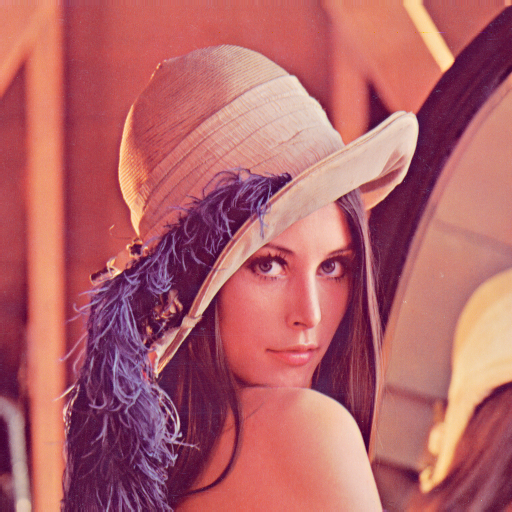

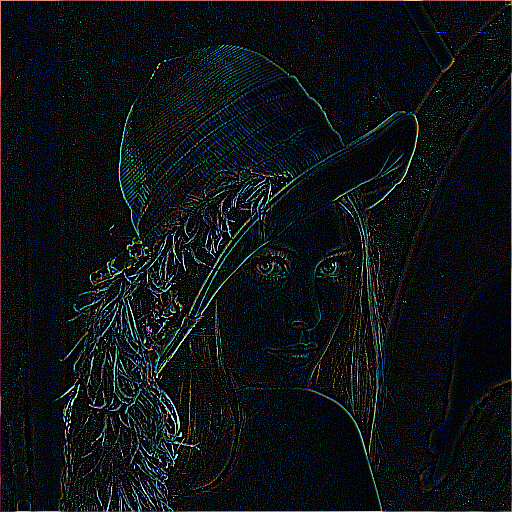

In [1]:
import numpy
from PIL import ImageFilter, Image as I
from IPython.display import display

# Opening the image (R prefixed to string
# in order to deal with '\' in paths)
path = "lenna.png"
image = I.open(path)
display(image)

# Calculating Edges using the passed Laplacian Kernel
final = image.filter(ImageFilter.Kernel((3, 3), (-1, -1, -1, -1, 8, -1, -1, -1, -1), 1, 0))
display(final)

### Laplaciano Sequencial 2D (Validação)

In [3]:
%%writefile laplacian-2d-sequential.c
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <math.h>

void populationMatrix2D(double *a, int rows, int jsta, int jend) {
    
   for (int i = 0; i < rows; i++)
     for (int j = jsta - 1; j < jend; j++)
            a[i + j * rows] = (i + j + 2) * 1.;  /*stored dates in column (major column)*/

}

void showMatrix(double *a, int n) {

   for (int i = 0; i < n; i++) {
      for (int j = 0; j < n; j++) {
        printf("%1.2f\t", a[i + j * n]);
      }
    printf("\n");
   }
   printf("\n");
}

void showVector(int *a, int n) {

   for (int i = 0; i < n; i++)
     printf("%d\t", a[i]);

   printf("\n\n");

}

void kernel(double *a, double *c,  int m, int n, int jsta2, int jend2, int dx, int dz) {

  double sx, sz;

  for (int j = jsta2 - 1; j < jend2; j++) {
     for (int i = 1; i < (m - 1); i++){
            sx = a[(i - 1) + j * n]  + a[(i + 1) + j * n]  + 2 * a[i + j * n];
            sz = a[i + (j - 1) * n]  + a[i + (j + 1) * n]  + 2 * a[i + j * n];
            c[i + j * n] = (sx/(dx*dx)) + (sz/(dz*dz));      
     }   
  }

}

void PARA_RANGE(int n1,int n2, int nprocs, int myid, int jsta, int jend, int *vector_return){

   int iwork1 = (n2 - n1 + 1) / nprocs;
   int iwork2 = (n2 - n1 + 1) % nprocs;

   jsta   = (myid * iwork1) + n1 + fmin((double)myid, (double)iwork2);
   jend   = jsta + iwork1 - 1;

   if (iwork2 > myid)
    jend = jend + 1;

   vector_return[0] = jsta;
   vector_return[1] = jend;

}

int main (int argc, char *argv[]) {
    
   int rows    = atoi(argv[1]); 
   int columns = rows;
   int myid = 0;
   int nprocs = 1;
   double dx=1, dz=1;
   int jsta = 1, jend = 1, jsta2, jend2;
   int *vector_return = (int *) calloc (2, sizeof(int));
   
   double *a  =  (double*) calloc (rows * columns, sizeof(double));
   double *c  =  (double*) calloc (rows * columns, sizeof(double));

   PARA_RANGE(1, rows, nprocs, myid, jsta, jend, vector_return);

   jsta = vector_return[0];
   jend = vector_return[1];

   jsta2 = jsta;
   jend2 = jend;

   jsta2 = 2;         
   jend2 = columns - 1;
    
   populationMatrix2D(a, rows, jsta, jend);
   
   showMatrix(a, rows);    
       kernel(a, c, rows, columns, jsta2, jend2, dx, dz);
   showMatrix(c, rows); 
       
   free(a);
   free(c);
     
   return 0;
}

Overwriting laplacian-2d-sequential.c


In [4]:
!gcc laplacian-2d-sequential.c -o laplacian-2d-sequential -lm

In [5]:
!./laplacian-2d-sequential 8

2.00	3.00	4.00	5.00	6.00	7.00	8.00	9.00	
3.00	4.00	5.00	6.00	7.00	8.00	9.00	10.00	
4.00	5.00	6.00	7.00	8.00	9.00	10.00	11.00	
5.00	6.00	7.00	8.00	9.00	10.00	11.00	12.00	
6.00	7.00	8.00	9.00	10.00	11.00	12.00	13.00	
7.00	8.00	9.00	10.00	11.00	12.00	13.00	14.00	
8.00	9.00	10.00	11.00	12.00	13.00	14.00	15.00	
9.00	10.00	11.00	12.00	13.00	14.00	15.00	16.00	

0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
0.00	32.00	40.00	48.00	56.00	64.00	72.00	0.00	
0.00	40.00	48.00	56.00	64.00	72.00	80.00	0.00	
0.00	48.00	56.00	64.00	72.00	80.00	88.00	0.00	
0.00	56.00	64.00	72.00	80.00	88.00	96.00	0.00	
0.00	64.00	72.00	80.00	88.00	96.00	104.00	0.00	
0.00	72.00	80.00	88.00	96.00	104.00	112.00	0.00	
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	



### Laplaciano Sequencial 2D (Mensuração de tempo + Entradas de Cargas Variadas)

In [6]:
%%writefile laplacian-2d-sequential.c
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <math.h>
#include <omp.h>

void populationMatrix2D(double *a, int rows, int jsta, int jend) {
    
   for (int i = 0; i < rows; i++)
     for (int j = jsta - 1; j < jend; j++)
            a[i + j * rows] = (i + j + 2) * 1.;  /*stored dates in column (major column)*/

}

void showMatrix(double *a, int n) {

   for (int i = 0; i < n; i++) {
      for (int j = 0; j < n; j++) {
        printf("%1.2f\t", a[i + j * n]);
      }
    printf("\n");
   }
   printf("\n");
}

void showVector(int *a, int n) {

   for (int i = 0; i < n; i++)
     printf("%d\t", a[i]);

   printf("\n\n");

}

void kernel(double *a, double *c,  int m, int n, int jsta2, int jend2, int dx, int dz) {

  double sx, sz;

  for (int j = jsta2 - 1; j < jend2; j++){
     for (int i = 1; i < (m - 1); i++){
            sx = a[(i - 1) + j * n]  + a[(i + 1) + j * n]  + 2 * a[i + j * n];
            sz = a[i + (j - 1) * n]  + a[i + (j + 1) * n]  + 2 * a[i + j * n];
            c[i + j * n] = (sx/(dx*dx)) + (sz/(dz*dz));      
     }
  }

}

void PARA_RANGE(int n1,int n2, int nprocs, int myid, int jsta, int jend, int *vector_return){

   int iwork1 = (n2 - n1 + 1) / nprocs;
   int iwork2 = (n2 - n1 + 1) % nprocs;

   jsta   = (myid * iwork1) + n1 + fmin((double)myid, (double)iwork2);
   jend   = jsta + iwork1 - 1;

   if (iwork2 > myid)
    jend = jend + 1;

   vector_return[0] = jsta;
   vector_return[1] = jend;

}

int main (int argc, char *argv[]) {
    
   int rows    = atoi(argv[1]); 
   int columns = rows;
   int myid = 0;
   int nprocs = 1;
   double dx = 1, dz = 1;
   int jsta = 1, jend = 1, jsta2, jend2;
   int *vector_return = (int *) calloc (2, sizeof(int));
   double t1, t2;
     
   double *a  =  (double*) calloc (rows * columns, sizeof(double));
   double *c  =  (double*) calloc (rows * columns, sizeof(double));

   PARA_RANGE(1, rows, nprocs, myid, jsta, jend, vector_return);

   jsta = vector_return[0];
   jend = vector_return[1];

   jsta2 = jsta;
   jend2 = jend;

   jsta2 = 2;         
   jend2 = columns - 1;
   
   t1 = omp_get_wtime(); 
     populationMatrix2D(a, rows, jsta, jend);
     kernel(a, c, rows, columns, jsta2, jend2, dx, dz);
   t2 = omp_get_wtime();
    
   printf("%d x %d \t%1.3f\n",rows, columns, t2-t1);
    
   free(a);
   free(c);
     
   return 0;
}

Overwriting laplacian-2d-sequential.c


In [7]:
%%writefile script-2d.sh
for i in 1024 4096 6144 8192 10240 14336 18432 22528 27648 46340
do
./$1 $i
done

Overwriting script-2d.sh


In [8]:
!gcc laplacian-2d-sequential.c -o laplacian-2d-sequential -fopenmp -lm -O3

In [9]:
!bash script-2d.sh laplacian-2d-sequential

1024 x 1024 	0.010
4096 x 4096 	0.256
6144 x 6144 	0.610
8192 x 8192 	1.267
10240 x 10240 	1.686
14336 x 14336 	3.385
18432 x 18432 	6.912
22528 x 22528 	8.460
27648 x 27648 	15.100
46340 x 46340 	24.806


## Análise dos Custos Computacionais da Aplicação Sequencial (Profilling)

<p style='text-align: justify;'> 
Conhecendo o algoritmo sequencial 2D faz-se necessário mensurar os pontos do código que exigem maior custo computacional da aplicação,  para que possamos focar nossos esforços na paralelização desses trechos, desta maneira, conseguimos trabalhar de forma inteligente, onde o código realmente precisa ganhar desempenho. Para a realização dessa etapa, será utilizado uma ferramenta denominada GNU profiler (gprof) que faz parte do conjunto GNU Binary Utilities (binutils), que tem como principal funcionalidade analisar e capturar os tempos durante a execução do código, gerando relátorios de desempenho. 
</p>  

Para executar o processo de profilling basta inserir o argumento _-pg_ na compilação do nosso código sequencial, executá-lo normalmente para gerar o arquivo binário do relatório e, logo depois, exibi-lo de forma legível através do comando associados ao gprof, ilustra-se a seguir: 

In [15]:
!gcc laplacian-2d-sequential.c -o laplacian-2d-sequential -fopenmp -lm -pg

In [16]:
!./laplacian-2d-sequential 27648

27648 x 27648 	49.652


In [17]:
!gprof -b laplacian-2d-sequential gmon.out

Flat profile:

Each sample counts as 0.01 seconds.
  %   cumulative   self              self     total           
 time   seconds   seconds    calls   s/call   s/call  name    
 84.06     41.74    41.74        1    41.74    41.74  populationMatrix2D
 16.10     49.73     7.99        1     7.99     7.99  kernel
  0.00     49.73     0.00        1     0.00     0.00  PARA_RANGE

			Call graph


granularity: each sample hit covers 2 byte(s) for 0.02% of 49.73 seconds

index % time    self  children    called     name
                                                 <spontaneous>
[1]    100.0    0.00   49.73                 main [1]
               41.74    0.00       1/1           populationMatrix2D [2]
                7.99    0.00       1/1           kernel [3]
                0.00    0.00       1/1           PARA_RANGE [4]
-----------------------------------------------
               41.74    0.00       1/1           main [1]
[2]     83.9   41.74    0.00       1         populationMatrix2D

Após a geração dos relatórios, podemos concluir estratégias de paralelismo para definir os próximos passos do processo de otimização. Pode-se observar que a aplicação 2D não tem impacto significativo no tempo de execução do algoritmo, em contrapartida, o mesmo modelo em 2D teria.

### Consumo de Memória  (GB)

\begin{equation}
M =  2 \cdot \frac{n \cdot n \cdot sizeof(double)}{(1024)^3}
\end{equation}

O valor de $n$ máximo possível seria exatamente $46340$, tamanho a partir do qual passou a apresentar `Segmentation Fault`, considerando $2$ matrizes: $a$ e $c$.

\begin{equation}
n_{max} = \sqrt{\frac{M \cdot (1024)^3}{sizeof(double) \cdot 2}} = \sqrt{\frac{32 \cdot 1073741824}{8 \cdot 2}}
 = 46340
\end{equation}

---
## Aplicações Paralelas

### Multicore (OPENMP)

In [18]:
%%writefile laplacian-2d-omp.c
/*TODO*/

Overwriting laplacian-2d-omp.c


In [19]:
!gcc laplacian-2d-omp.c -o laplacian-2d-omp -fopenmp -lm -O3

In [20]:
%%writefile script-2d-omp.sh
for i in 1024 4096 6144 8192 10240 14336 18432 22528 27648 46340
do
OMP_NUM_THREADS=$2 ./$1 $i
done

Overwriting script-2d-omp.sh


In [21]:
!bash script-2d-omp.sh laplacian-2d-omp 256

1024 x 1024 	0.014
4096 x 4096 	0.066
6144 x 6144 	0.136
8192 x 8192 	0.285
10240 x 10240 	0.508
14336 x 14336 	0.836
18432 x 18432 	1.725
22528 x 22528 	2.545
27648 x 27648 	4.187
46340 x 46340 	9.190


### Multiprocessor (MPI)

In [25]:
%%writefile laplacian-2d-mpi.c
/*TODO*/

Overwriting laplacian-2d-mpi.c


In [26]:
!mpicc laplacian-2d-mpi.c -o laplacian-2d-mpi -fopenmp -lm -O3

In [27]:
!mpirun -np 8 ./laplacian-2d-mpi 46340

--------------------------------------------------------------------------

  Local host:   c000
  Local device: mlx5_0
--------------------------------------------------------------------------
[c000:66753] 7 more processes have sent help message help-mpi-btl-openib.txt / error in device init
[c000:66753] Set MCA parameter "orte_base_help_aggregate" to 0 to see all help / error messages
46340 x 46340 	32.219


### Multiprocessor + Multicore (MPI + OpenMP)

In [28]:
%%writefile laplacian-2d-mpi+omp.c
/*TODO*/

Overwriting laplacian-2d-mpi+omp.c


In [31]:
!mpicc laplacian-2d-mpi+omp.c -o laplacian-2d-mpi+omp -fopenmp -lm -O3

In [34]:
!OMP_NUM_THREADS=32 mpirun -np 8 ./laplacian-2d-mpi+omp 46340

--------------------------------------------------------------------------

  Local host:   c000
  Local device: mlx5_0
--------------------------------------------------------------------------
[c000:08935] 7 more processes have sent help message help-mpi-btl-openib.txt / error in device init
[c000:08935] Set MCA parameter "orte_base_help_aggregate" to 0 to see all help / error messages
46340 x 46340 	32.199


### 1 GPU (CUDA)

In [37]:
%%writefile laplacian-2d-1GPU.cu
/*TODO*/

Overwriting laplacian-2d-1GPU.cu


In [38]:
!nvcc laplacian-2d-1GPU.cu -o laplacian-2d-1GPU -Xcompiler -fopenmp -O3

In [39]:
!./laplacian-2d-1GPU 46340

46340 x 46340 	22.202


### 1 GPU (CUDA) - cudaMallocManaged

In [40]:
%%writefile laplacian-2d-1GPU-cudaMallocManaged.cu
/*TODO*/

Overwriting laplacian-2d-1GPU-cudaMallocManaged.cu


In [41]:
!nvcc laplacian-2d-1GPU-cudaMallocManaged.cu -o laplacian-2d-1GPU-cudaMallocManaged -Xcompiler -fopenmp -O3

In [42]:
!./laplacian-2d-1GPU-cudaMallocManaged 46340

46340 x 46340 	3.379205324 


In [19]:
%%writefile script-2d-cuda.sh
for i in 1024 4096 6144 8192 10240 14336 18432 22528 27648 46340
do
./$1 $i
done

Overwriting script-2d-cuda.sh


In [20]:
!bash script-2d-cuda.sh laplacian-2d-1GPU-cudaMallocManaged

1024 x 1024 	0.002399142 
4096 x 4096 	0.028957088 
6144 x 6144 	0.051476347 
8192 x 8192 	0.075363851 
10240 x 10240 	0.126102092 
14336 x 14336 	0.235790492 
18432 x 18432 	0.414115797 
22528 x 22528 	0.650353573 
27648 x 27648 	1.019212364 
46340 x 46340 	3.339028901 


## Análise Experimental

### I) Validação com Valores Pequenos

#### Parâmetros Ótimos de Execução

1. OpenMP = **A** Threads
2. MPI = **B** nós + **C** Processos
3. MPI + OpenMP = **D** nós + **E** Processos + **F** Threads
4. CUDA = G1D B1DT1D (**G** * 32, 1024)

### Tempos de execução em segundos das aplicações

|  Entradas    | Sequencial | OpenMP | MPI  | Híbrido | CUDA
| ---------------------| ---------- | ------ | ---  | ------- | ----
| 1024 x 1024         |            |        |      |         |  
| 4096 x 4096         |            |        |      |         |  
| 6144 x 6144         |            |        |      |         |  
| 8192 x 8192         |            |        |      |         |  
| 10240 x 10240        |            |        |      |         |  
| 18432 x 18432         |            |        |      |         |  
| 27648 x 27648        |            |        |      |         |  

### Speedups

|  Entradas             |  OpenMP    | MPI     | Híbrido       | CUDA
| ---------             | ------     | ------  | -------       | ----
| 1024 x 1024           |       |        |      |           
| 4096 x 4096           |      |        |      |           
| 6144 x 6144           |       |        |      |           
| 8192 x 8192           |      |        |      |           
| 10240 x 10240         |       |        |      |          
| 18432 x 18432         |       |        |      |          
| 27648 x 27648         |     |        |      |    

### II) Análise de Desempenho - `46340`

#### Parâmetros Ótimos de Execução

1. OpenMP = **A** Threads
2. MPI = **B** nós + **C** Processos
3. MPI + OpenMP = **D** nós + **E** Processos + **F** Threads
4. CUDA = G1D B1DT1D (**G** * 32, 1024)

### Tempo de execução em segundos das aplicações

|  Entradas    | Sequencial | OpenMP | MPI      | Híbrido | CUDA
| -------------| ---------- | ------ | ---      | ------- | ----
| 46340 x 46340|   29.324   |   9.19 |   32.21  |   32.19 | 3.33  


### Speedup

|  Senha          |  OpenMP    | MPI     | Híbrido  | CUDA
|-----------------|------------|---------|----------| ----
| 46340 x 46340   |  3.19X     |   -     |  -       |  8.8X


## Conclusões

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

## Referências Biliográficas

* G. Coulouris, J. Dollimore, T. Kindberg, G.Blair. Distributed Systems: Concepts and Design, Fifth Edition, Pearson, 2011.

* S.Tanenbaum, M. Steen, Distributed Systems: Principles and Paradigms, Second Edition, Pearson, 2006.

* David A. Patterson and John L. Hennessy. Computer Organization and Design: The Hardware/Software Interface. Morgan Kaufmann, 5th Edition, 2013.

* An Introduction to Parallel Programming by Peter S. Pacheco. Morgan Kauffman.

* W. C. Barbosa, An introduction to distributed algorithms, MIT Press, 1997. N. Lynch, Distributed Algorithms, Mit Press, 1996 e Introduction to Distributed Algorithms, Gerard Tel, Cabribridge U. Press, 1994.